# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [1]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
from scipy.optimize import curve_fit
import seaborn as sb
#import seaborn as sb


In [3]:
workdir='/Users/NLoui/Desktop/Chem101_S24/Exercise1/'
datadir='/Users/NLoui/Desktop/Chem101_S24/Exercise1/data/'
outdir='/Users/Nloui/Desktop/Chem101_S24/Exercise1/outdir/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/NLoui/Desktop/Chem101_S24/Exercise1/data/butane.pdb
/Users/NLoui/Desktop/Chem101_S24/Exercise1/data/butane.gaff2.xml


In [4]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295271861905623 kJ/mol


In [5]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,46.87854989050726,294.18250224905614
2000,40.19380939525627,317.4642489876927


In [6]:
os.path.join(workdir, "butane_sim.dcd")

'/Users/NLoui/Desktop/Chem101_S24/Exercise1/butane_sim.dcd'

In [7]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,33.34309453281346,233.64369600169826,0
500000,999.9999999901769,25.121566232972302,443.1895394963043,2.25e+04
750000,1499.9999999783536,56.15526140761669,200.85719431337037,2.17e+04
1000000,1999.9999999665301,48.074495516555274,330.166399276826,2.15e+04
1250000,2499.9999999547067,57.248703624664856,189.1116039373646,2.16e+04
1500000,2999.9999999428833,43.54350975800844,269.13222479575734,2.15e+04
1750000,3499.99999993106,43.62053655132459,276.7695680200245,2.14e+04
2000000,3999.9999999192364,47.88793315203711,271.8378970055885,2.14e+04
2250000,4499.9999999992715,48.71349065173362,336.3137797132756,2.14e+04
2500000,5000.000000101135,53.94947139677271,321.87836393718476,2.13e+04
2750000,5500.000000202998,64.35827297250728,293.7251574338047,2.12e+04
3000000,6000.000000304862,19.83152495990969,334.0574656450113,2.13e+04
3250000,6500.000000406725,39.486008530762

In [8]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.dcd"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x14464da10>

In [9]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [10]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x14945b550>

In [11]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


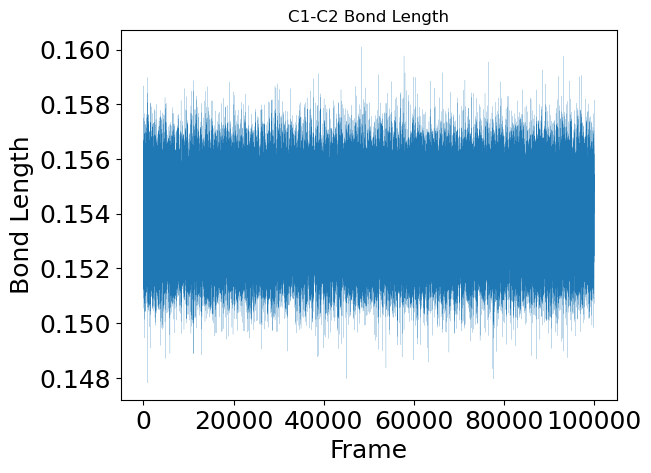

In [12]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C1C2bondlength,linewidth=0.1)
#plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

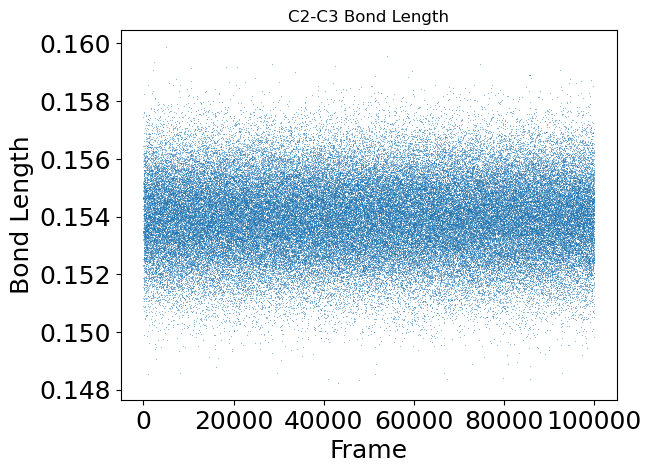

In [13]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

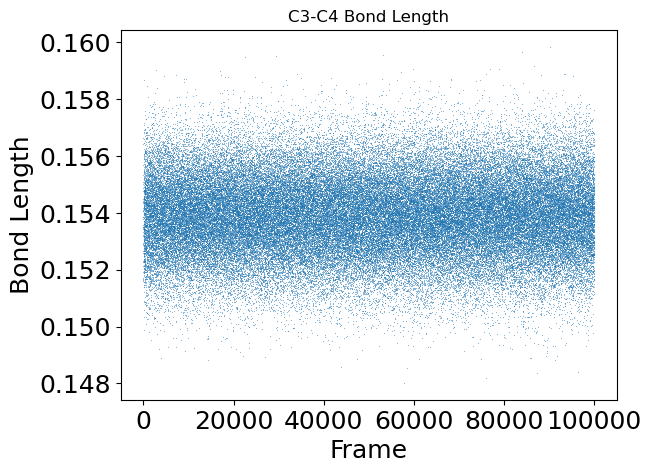

In [14]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

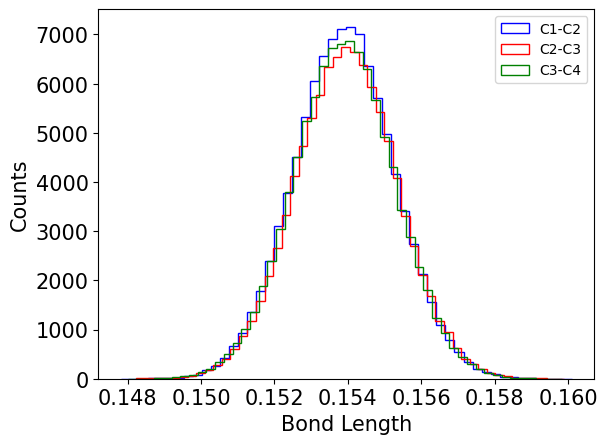

In [15]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

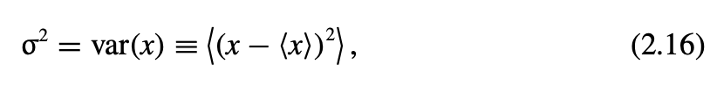

In [16]:
######Class Activity: Calculate the Variance and Standard Deviation of Each Bond Length######


In [17]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)

print("C1-C2 variance:",C1C2var,"C1-C2 standard deviation:",C1C2std)
print("C2-C3 variance:",C2C3var,"C1-C2 standard deviation:",C2C3std)
print("C3-C4 variance:",C2C3var,"C1-C2 standard deviation:",C3C4std)

C1-C2 variance: 1.8667009e-06 C1-C2 standard deviation: 0.0013662726401295884
C2-C3 variance: 1.9078755e-06 C1-C2 standard deviation: 0.0013812586497895685
C3-C4 variance: 1.9078755e-06 C1-C2 standard deviation: 0.0013720679134639794


In [18]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15390004 variance: 1.8667009e-06 std-dev: 0.0013662727
C2-C3 average: 0.15395267 variance: 1.9078755e-06 std-dev: 0.0013812586
C3-C4 average: 0.15389709 variance: 1.8825704e-06 std-dev: 0.001372068


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


In [19]:
#Switch to a 1D array 
np.shape(C1C2bondlength[:,0])

(100000,)

Line Parameters: [0.50014928 0.07697602]


/Users/NLoui/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


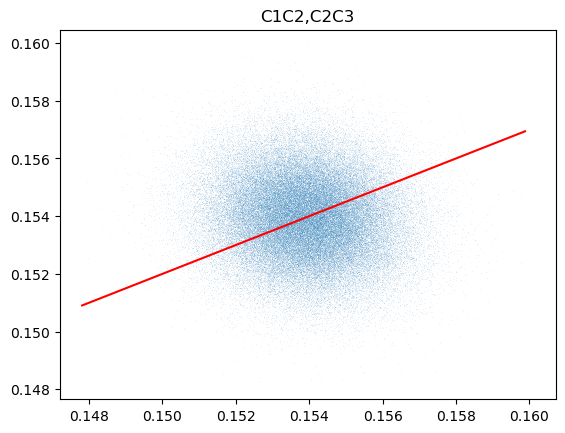

/Users/NLoui/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


r2: -0.10119428964564506
Line Parameters: [0.49997082 0.07694856]


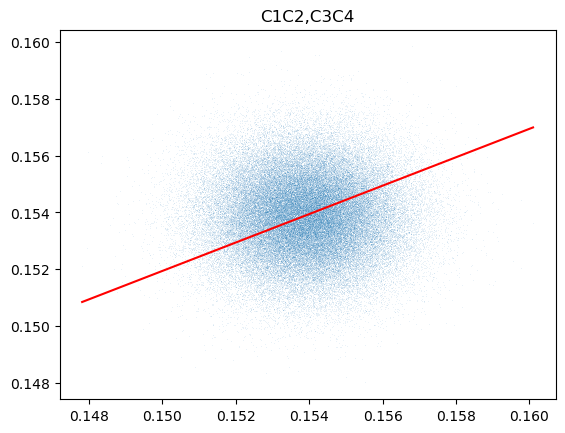

r2: 0.0028764796574205784


In [92]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)
plt.title('C1C2,C2C3')

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)
plt.title('C1C2,C3C4')

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

<Figure size 640x480 with 0 Axes>

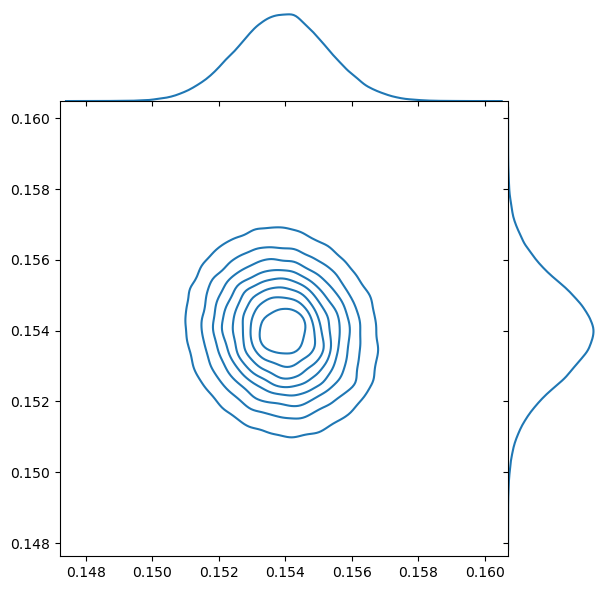

In [21]:
#In Class Activity
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='kde',space=0,thresh=0)

<Figure size 640x480 with 0 Axes>

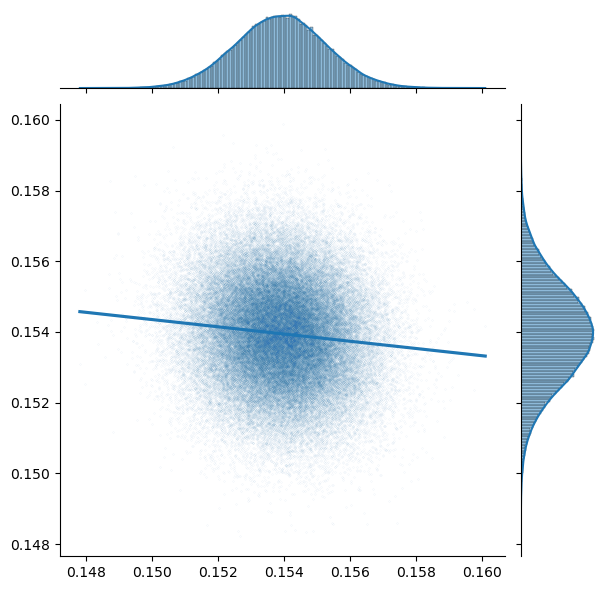

In [22]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='reg',scatter_kws={'s':0.001})

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**


The pearson correlation coefficient defines the link between the r^2 values and correlation. If r is close to 1 or -1, it has a strong correlation. If r is close to 0, there is no or minimal linear correlation. 

Based on the r^2 values, the bonds C1C2 and C2C3 are more correlated. This makes sense as the bonds are attached to the same carbon and the bond length would be affected if the other is affected.

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

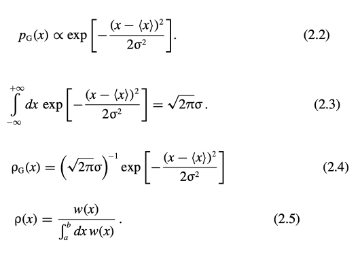
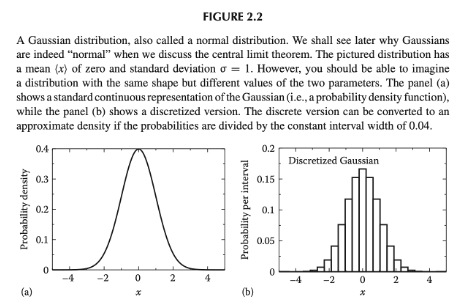

[    0     3    16    52   283  1025  2932  6464 11331 16349 18608 17474
 12654  7436  3491  1368   398    91    21     3] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
a: 0.18785828633396862 x_0: 0.1539037822755326 fit_sigma: 0.001380364337147534


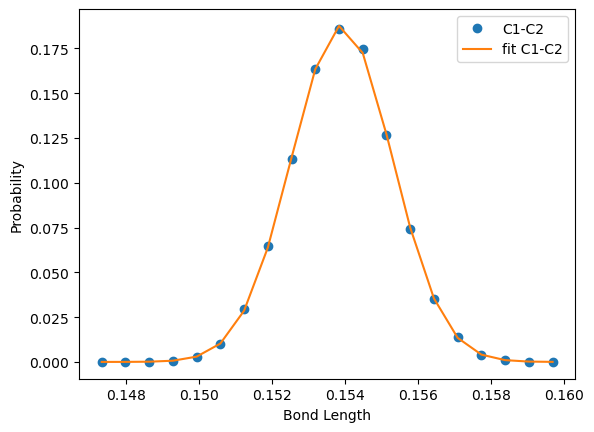

In [23]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#instead of bin edges and counts:
counts, edges = np.histogram(C1C2bondlength,bins=20,range=[0.147,0.160])
print(counts,edges)
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR  ####


###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit
def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]


C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers,density,'o',label='C1-C2')
plt.plot(centers,C1C2_fit,'-',label='fit C1-C2')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

a: 0.18785822616004058 x_0: 0.07711439164425966 fit_sigma: -0.0006901820180130373
a: 0.18590323439922557 x_0: 0.07713789720825048 fit_sigma: 0.0006976464948471251
a: 0.18785545609436285 x_0: 0.07711094038328976 fit_sigma: -0.0006893354889809577


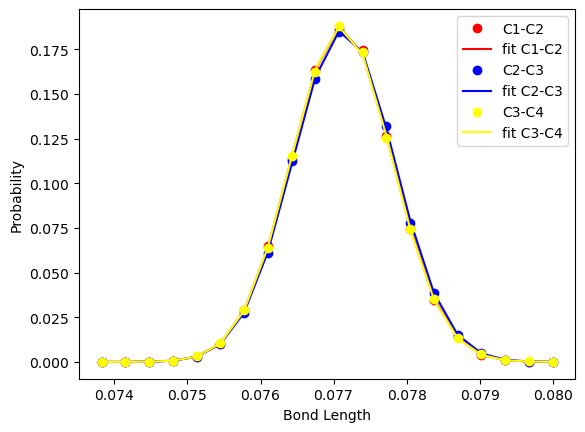

In [55]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####
#function histogram to probability densities aka density
def pdf(data, bins, range):
    counts, edges = np.histogram(data, bins=bins, range=range)
    centers = (edges[:-1] + np.diff(edges)) / 2
    #bin_width = edges[1] - edges[0]
    density = counts / (np.sum(counts))
    return centers, density

#C1C2density_centers[0] = centers, C1C2density_centers[1] = density

#C1C2 bond centers and density
C1C2_pdf=pdf(C1C2bondlength,bins=20,range=[0.147,0.160])


C1C2_fit,C1C2_fit_params=fit_gauss(C1C2_pdf[0],C1C2_pdf[1])
plt.plot(C1C2_pdf[0],C1C2_pdf[1],'o',label='C1-C2',color='red')
plt.plot(C1C2_pdf[0],C1C2_fit,'-',label='fit C1-C2',color='red')

#C2C3 bond centers and density
C2C3_pdf=pdf(C2C3bondlength,bins=20,range=[0.147,0.160])
#print(C2C3density_centers)

C2C3_fit,C2C3_fit_params=fit_gauss(C2C3_pdf[0],C2C3_pdf[1])

plt.plot(C2C3_pdf[0],C2C3_pdf[1],'o',label='C2-C3',color='blue')
plt.plot(C2C3_pdf[0],C2C3_fit,'-',label='fit C2-C3',color='blue')

#C2C3 bond centers and density
C3C4_pdf=pdf(C3C4bondlength,bins=20,range=[0.147,0.160])

C3C4_fit,C3C4_fit_params=fit_gauss(C3C4_pdf[0],C3C4_pdf[1])

plt.plot(C3C4_pdf[0],C3C4_pdf[1],'o',label='C3-C4',color='yellow')
plt.plot(C3C4_pdf[0],C3C4_fit,'-',label='fit C3-C4',color='yellow')

plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()





In [57]:
print(C1C2_pdf[0],C1C2_pdf[1])

[0.073825 0.07415  0.074475 0.0748   0.075125 0.07545  0.075775 0.0761
 0.076425 0.07675  0.077075 0.0774   0.077725 0.07805  0.078375 0.0787
 0.079025 0.07935  0.079675 0.08    ] [0.00000000e+00 3.00003000e-05 1.60001600e-04 5.20005200e-04
 2.83002830e-03 1.02501025e-02 2.93202932e-02 6.46406464e-02
 1.13311133e-01 1.63491635e-01 1.86081861e-01 1.74741747e-01
 1.26541265e-01 7.43607436e-02 3.49103491e-02 1.36801368e-02
 3.98003980e-03 9.10009100e-04 2.10002100e-04 3.00003000e-05]


**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

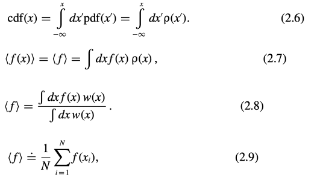

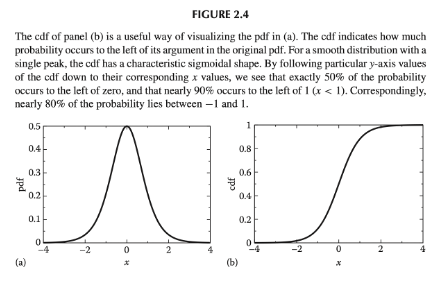

a: 1.0870171342450796 x_0: 0.07899749032349762 fit_sigma: 0.0015641423500723718
a: 1.0849327573891974 x_0: 0.07901271153414774 fit_sigma: -0.00155851819906649
a: 1.0866126950703912 x_0: 0.07899761901087504 fit_sigma: 0.001565936045725245


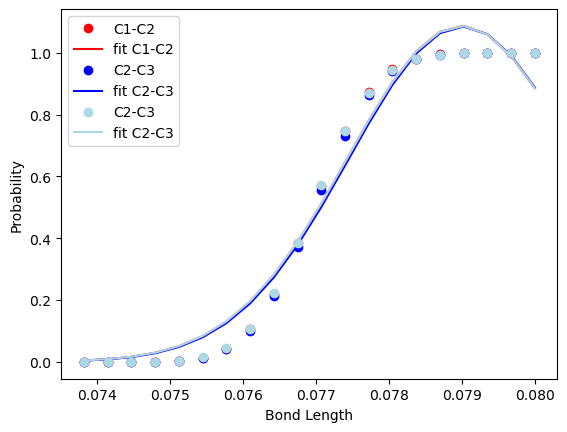

In [25]:
###WEEK 1 HOMEWORK Q2 #### 

####HOMEWORK SOLUTION####
def pdf_to_cdf(centers, density):
    cdf = np.cumsum(density)
    return centers, cdf
#ADD CODE FOR CDFs HERE#

#C1C2 bond centers and cumulative density

C1C2_cdf=pdf_to_cdf(C1C2_pdf[0],C1C2_pdf[1]) 

C1C2cdf_fit,C1C2cdf_fit_params=fit_gauss(C1C2_cdf[0],C1C2_cdf[1])
plt.plot(C1C2_cdf[0],C1C2_cdf[1],'o',label='C1-C2',color='red')
plt.plot(C1C2_cdf[0],C1C2cdf_fit,'-',label='fit C1-C2',color='red')

#C2C3 bond centers and cumulative density

C2C3_cdf=pdf_to_cdf(C2C3_pdf[0],C2C3_pdf[1]) 

C2C3cdf_fit,C2C3cdf_fit_params=fit_gauss(C2C3_cdf[0],C2C3_cdf[1])
plt.plot(C2C3_cdf[0],C2C3_cdf[1],'o',label='C2-C3',color='blue')
plt.plot(C2C3_cdf[0],C2C3cdf_fit,'-',label='fit C2-C3',color='blue')

#C3C4 bond centers and cumulative density

C3C4_cdf=pdf_to_cdf(C3C4_pdf[0],C3C4_pdf[1]) 

C3C4cdf_fit,C3C4cdf_fit_params=fit_gauss(C3C4_cdf[0],C3C4_cdf[1])
plt.plot(C3C4_cdf[0],C3C4_cdf[1],'o',label='C2-C3',color='lightblue')
plt.plot(C3C4_cdf[0],C3C4cdf_fit,'-',label='fit C2-C3',color='lightblue')

plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()


**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle ***
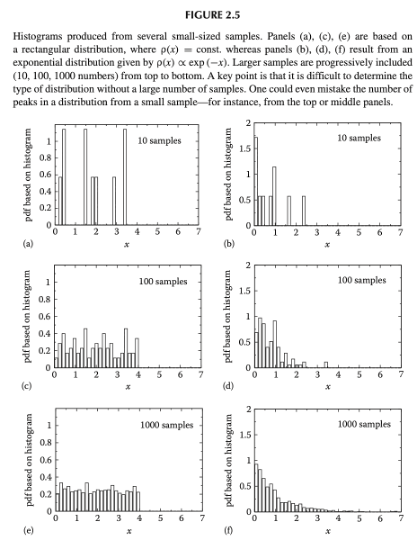

a: 1.1027372060855636 x_0: 0.07893953379828479 fit_sigma: 0.0015357094934931826

NOT A GOOD FIT at all!!!!!


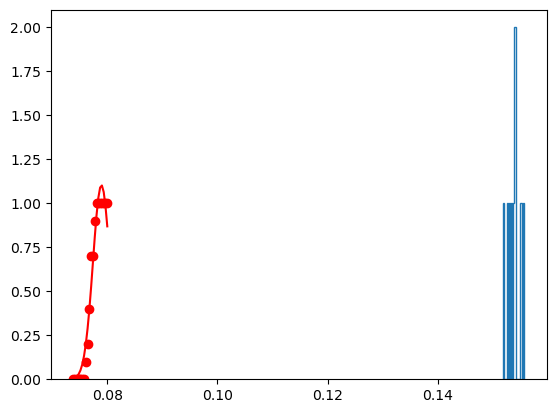

In [68]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

#This function might be helpful:
rands=np.random.randint(10000, size=(10))
rands
C1C2bond=C1C2bondlength[:,0]
C1C2bond[rands]
plt.hist(C1C2bond[rands],bins=20,histtype='step')
#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?

c1c2bond_pdf=pdf(C1C2bond[rands],bins=20,range=[0.147,0.160])
c1c2bond_cdf=pdf_to_cdf(c1c2bond_pdf[0],c1c2bond_pdf[1])


c1c2bond_cdf_fit,c1c2bond_cdf_fit_params=fit_gauss(c1c2bond_cdf[0],c1c2bond_cdf[1])
plt.plot(c1c2bond_cdf[0],c1c2bond_cdf[1],'o',label='C1-C2',color='red')
plt.plot(c1c2bond_cdf[0],c1c2bond_cdf_fit,'-',label='fit C1-C2',color='red')

print()
print('NOT A GOOD FIT at all!!!!!')

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

(100000, 2)
[[1.978849  1.8820012]
 [1.9686828 1.9383942]
 [1.9421009 1.9425825]
 ...
 [2.0093007 1.9904877]
 [1.9926944 2.0131848]
 [1.916105  1.9384718]]


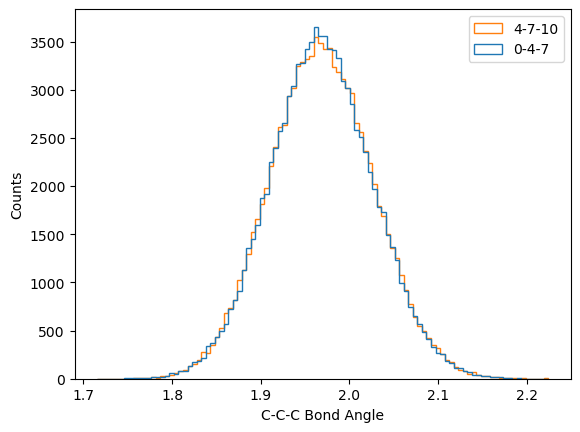

[[ 3.13791  ]
 [-3.0404809]
 [ 2.7795494]
 ...
 [-2.9603834]
 [ 3.0299988]
 [ 3.0808318]]
[[ 179.78899]
 [-174.20671]
 [ 159.25644]
 ...
 [-169.61746]
 [ 173.60612]
 [ 176.51865]]


Text(0, 0.5, 'Phi (deg), dihedral changes')

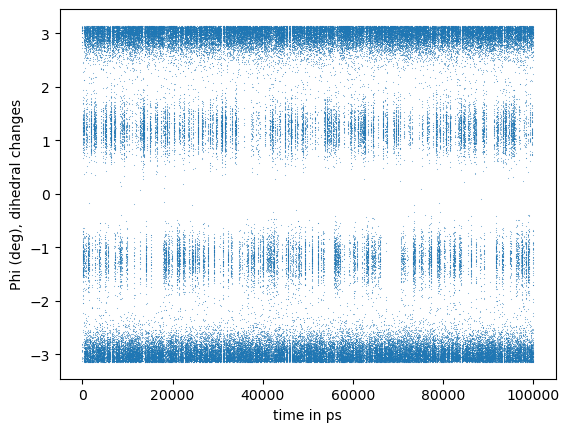

In [59]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
plt.xlabel('time in ps')
plt.ylabel('Phi (deg), dihedral changes')
#plt.xlim([0,100])

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [28]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe<0)
print(a)
CCCC_dihe[a]
b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)
CCCC_dihe[c]

#CCCC_dihe[c] is the higher free energy states
higher_energy_occ=len(CCCC_dihe[c])
total_occ=len(CCCC_dihe)

prob=higher_energy_occ/total_occ
print("Probability of being in the higher free energy state:", prob)



(array([    1,     3,     6, ..., 99993, 99994, 99997]),)
(array([    0,     2,     4, ..., 99996, 99998, 99999]),)
(array([   44,    45,    46, ..., 99991, 99992, 99993]),)
Probability of being in the higher free energy state: 0.10156


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: 0.0019726609107470886


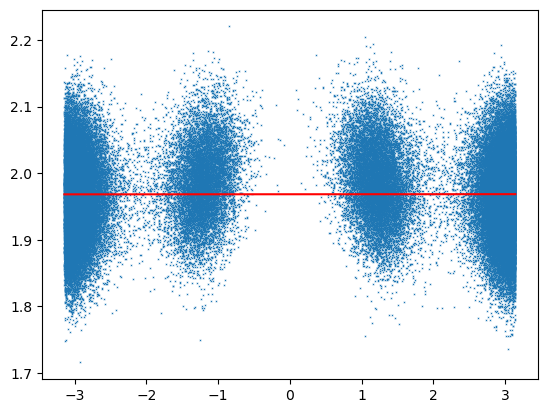

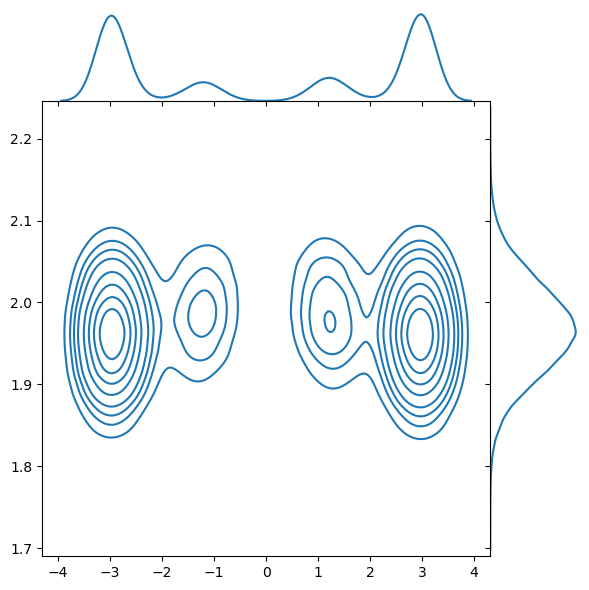

In [29]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?

CCCC_dihe

plt.scatter(CCCC_dihe,ang1,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_dihe,ang1,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
##### ADD FANCY SEABORN PLOT HERE ######
sns.jointplot(x=CCCC_dihe,y=ang1,kind='kde',space=0,thresh=0)

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

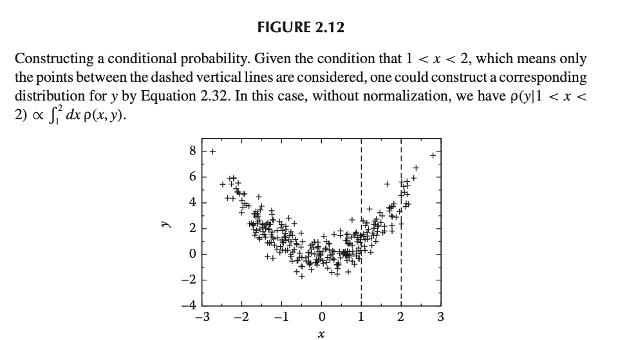

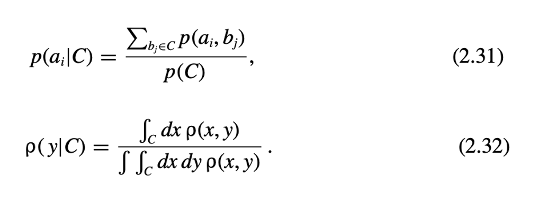

In [30]:
#Homework problem 3 Solution ##

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe
a=np.where(CCCC_dihe<0)
print(a)
CCCC_dihe[a]
b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)
CCCC_dihe[c]

(array([    1,     3,     6, ..., 99993, 99994, 99997]),)
(array([    0,     2,     4, ..., 99996, 99998, 99999]),)
(array([   44,    45,    46, ..., 99991, 99992, 99993]),)


array([-0.6952502, -1.3904467, -1.1814252, ..., -1.0221012, -1.7025379,
       -0.7019084], dtype=float32)

In [31]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[1.978849  1.9686828 1.9421009 ... 2.0093007 1.9926944 1.916105 ]
[1.9686828 1.9421009 1.9481456 ... 2.0093007 1.9926944 1.916105 ]
[1.978849  1.9686828 1.9421009 ... 1.9042902 2.0093007 1.9926944]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


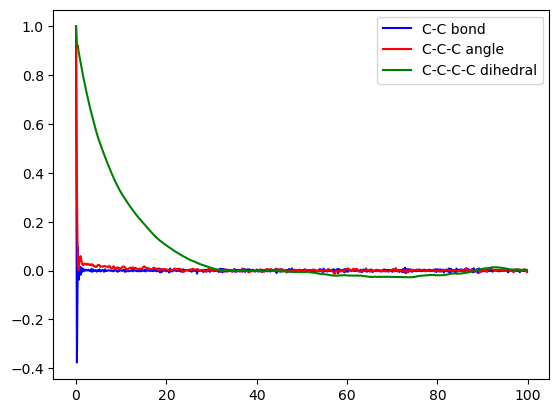

In [32]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

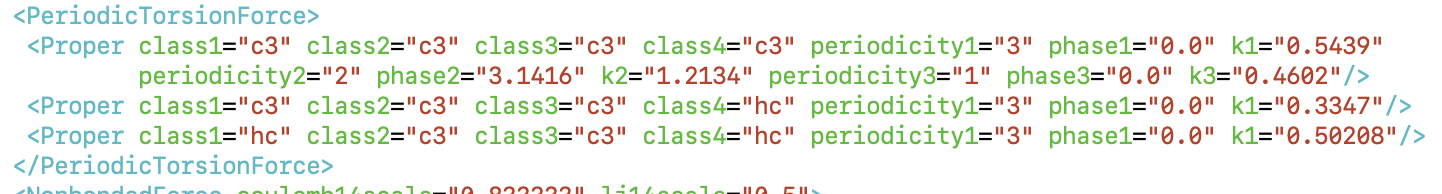

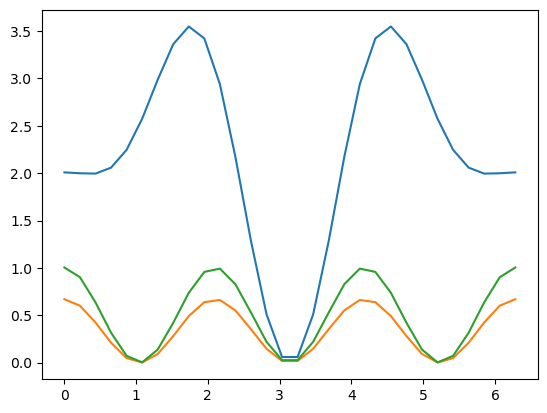

In [33]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms
def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)

In [34]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [35]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

(100000, 2)
[[1.8608528 1.8342088]
 [1.8703239 1.9864473]
 [1.945627  1.8732827]
 ...
 [1.961593  1.9880877]
 [2.0614846 1.8421255]
 [1.9369522 1.8246896]]
[[-3.0566041]
 [-2.8832104]
 [ 2.805311 ]
 ...
 [-2.986508 ]
 [ 2.8658288]
 [ 3.046843 ]]
[[-175.13051]
 [-165.19579]
 [ 160.73247]
 ...
 [-171.11429]
 [ 164.19989]
 [ 174.57124]]


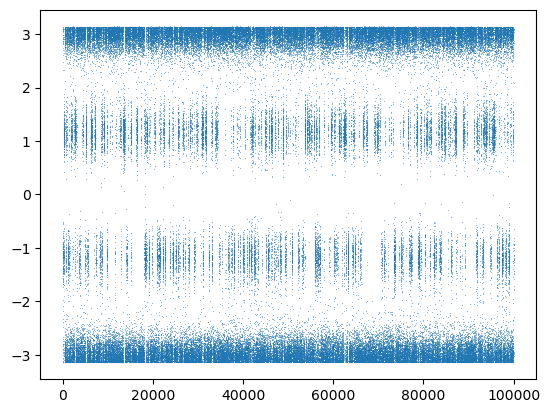

In [73]:
#H-C-C-H; [8,7,4,5]

HCCH_Angle1=[8,7,4]
HCCH_Angle2=[7,4,5]

ang = md.compute_angles(traj,[HCCH_Angle1,HCCH_Angle2])
print(np.shape(ang))
print(ang)

HCCH_ang1=ang[:,0]
HCCH_ang2=ang[:,1]

HCCH_index=[8,7,4,5]
HCCH_torsion=md.compute_dihedrals(traj, [HCCH_index])
print(HCCH_torsion)
print(np.rad2deg(HCCH_torsion))

plt.plot(HCCH_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

r2: 0.628114779231636


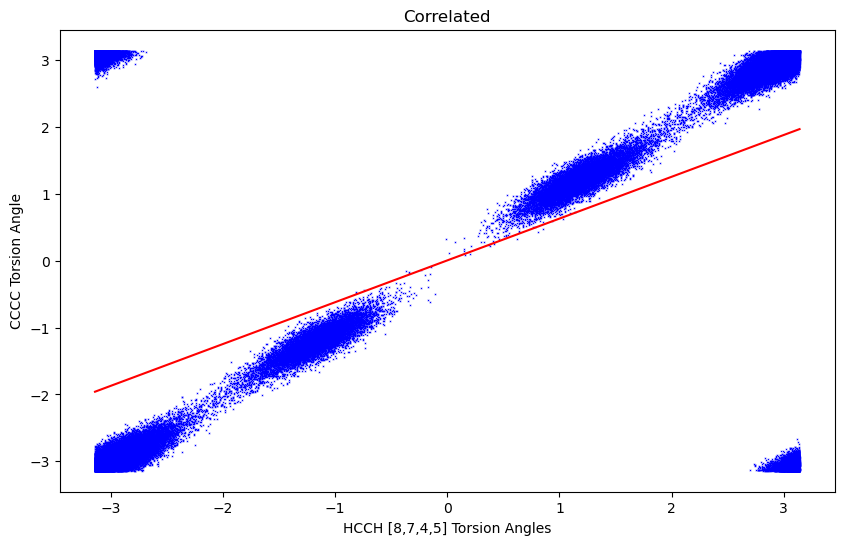

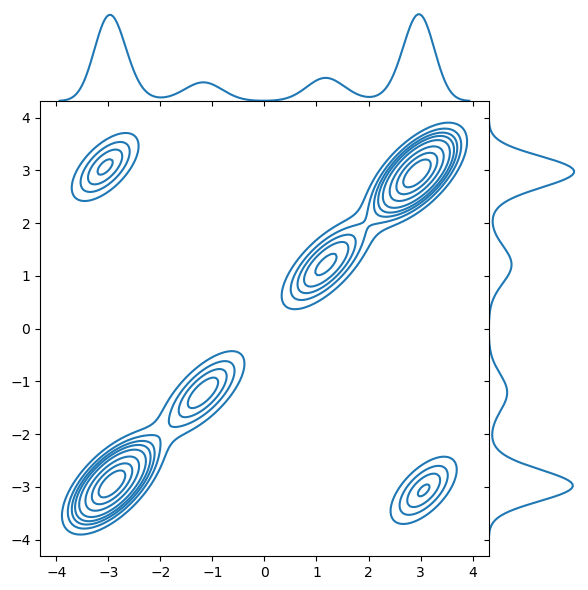

In [79]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Consider CCCC vs. [8,7,4,5]

# Extract torsional angles
HCCH_tor_8745 = HCCH_torsions[:, HCCH_indices.index([8, 7, 4, 5])]  # Extracting the first torsion angle from HCCH_torsions
CCCC_tor = CCCC_torsion[:, 0]    # Extracting the torsion angle from CCCC_torsion
#HCCH_angles_8746 = HCCH_torsions[:, HCCH_indices.index([8, 7, 4, 6])]


# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(HCCH_tor_8745, CCCC_tor, label='Correlated Torsions', marker='x',s=0.1,color='blue')
#plt.scatter(HCCH_angles_8745, HCCH_angles_8746, label='Correlated Torsions', color='lightblue')
r=np.corrcoef(CCCC_tor,HCCH_tor_8745)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_tor,HCCH_tor_8745,1)
line_fit
x=np.linspace(min(CCCC_tor),max(CCCC_tor),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')


# Set labels and title
plt.xlabel('HCCH [8,7,4,5] Torsion Angles')
plt.ylabel('CCCC Torsion Angle')
plt.title('Correlated')

plt.show()


sns.jointplot(x=HCCH_tor_8745,y=CCCC_tor,kind='kde',space=0,thresh=0)

r2: 0.01953623819925841


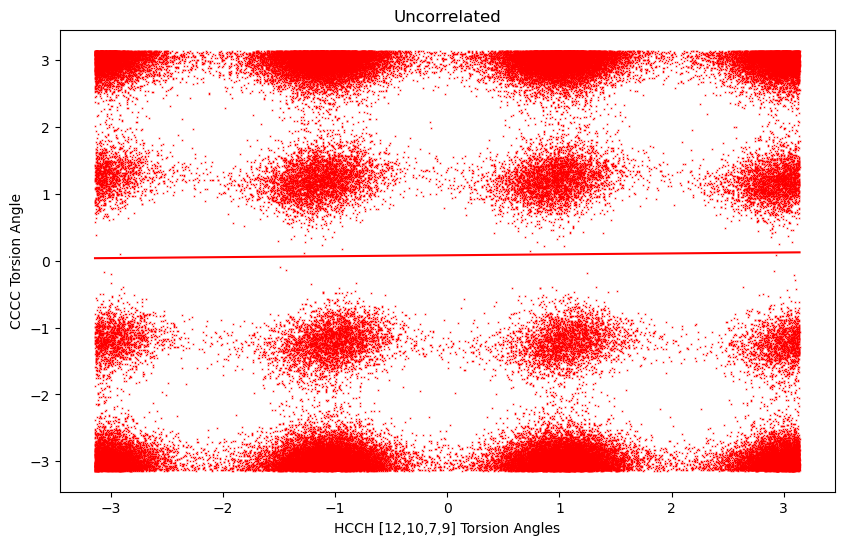

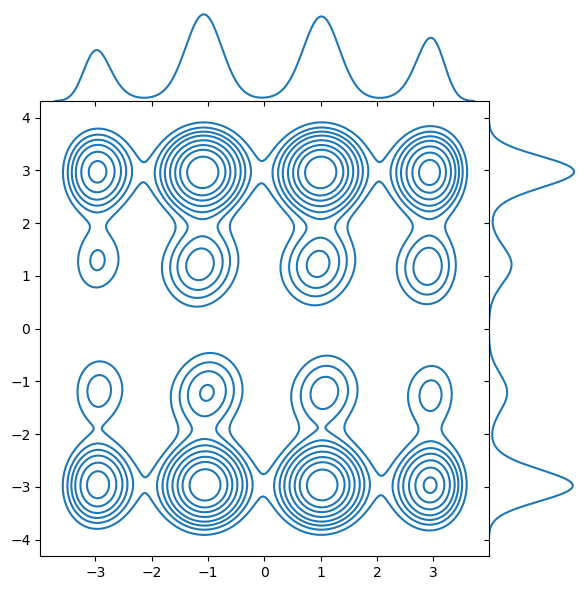

In [82]:
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]

# Extract torsional angles
HCCH_tor_12_10_7_9 = HCCH_torsions[:, HCCH_indices.index([12, 10, 7, 9])]  
CCCC_tor = CCCC_torsion[:, 0]    # Extracting the torsion angle from CCCC_torsion
#HCCH_angles_8746 = HCCH_torsions[:, HCCH_indices.index([8, 7, 4, 6])]


# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(HCCH_tor_12_10_7_9, CCCC_tor, label='UnCorrelated Torsions', marker='x',s=0.1,color='red')
#plt.scatter(HCCH_angles_8745, HCCH_angles_8746, label='Correlated Torsions', color='lightblue')
r=np.corrcoef(CCCC_tor,HCCH_tor_12_10_7_9)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_tor,HCCH_tor_12_10_7_9,1)
line_fit
x=np.linspace(min(CCCC_tor),max(CCCC_tor),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')


# Set labels and title
plt.xlabel('HCCH [12,10,7,9] Torsion Angles')
plt.ylabel('CCCC Torsion Angle')
plt.title('Uncorrelated')

plt.show()


sns.jointplot(x=HCCH_tor_12_10_7_9,y=CCCC_tor,kind='kde',space=0,thresh=0)


**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

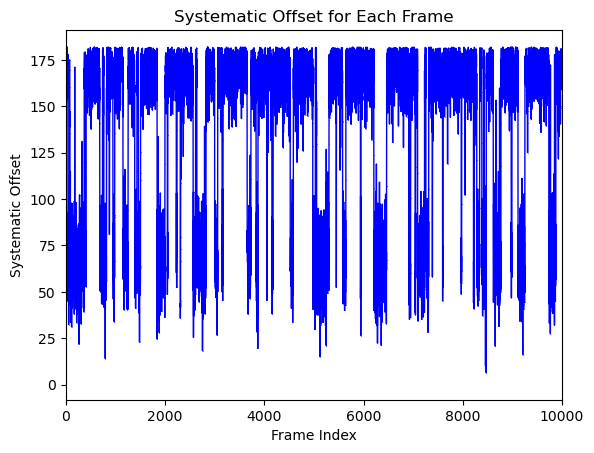

In [96]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT

#----------------------------------------------
#from class
HCCCH_tor_offset1=np.rad2deg(HCCH_tor_8745)
mean_angle=np.mean(HCCCH_tor_offset1)

HCCCH_tor_offsets=HCCCH_tor_offset1-mean_angle

plt.plot(np.abs(HCCCH_tor_offsets), marker='x', markersize=0.1, linewidth=1, color='blue')
plt.xlim([0, 10000]) 
plt.xlabel('Frame Index')
plt.ylabel('Systematic Offset')
plt.title('Systematic Offset for Each Frame')
plt.show()
#HCCCH_tor_offset2=np.rad2deg(HCCH_tor_12_10_7_9)

#print(CCCC_tor_offset)
#for i in range(0,len(CCCC_tor_offset)):
#    if(CCCC_tor_offset[i]<0):
#        CCCC_tor_offset[i]+=360
        
#plt.plot(np.abs(HCCCH_tor_offset1),marker='x',markersize=.1,linewidth=1,color='blue')
#plt.xlim([0,10000])


#----------------------------------------------
#plt.plot(np.abs(HCCCH_tor_offset2),marker='x',markersize=.1,linewidth=1,color='red')
#plt.xlim([0,5000])


In [ ]:
####WEEK 1 STOP HERE######

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

In [ ]:
###SOLUTION#####



***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [ ]:
#RUN NEW MD SIMULATION HERE#

In [ ]:
#Compare New Dihedral Distribution HERE)

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##


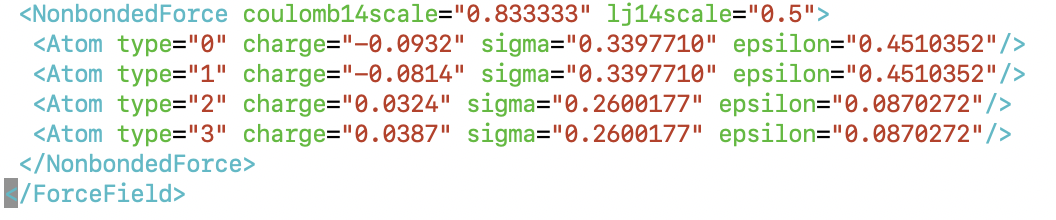




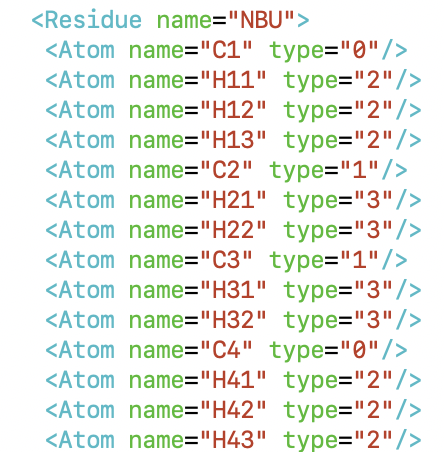

In [ ]:
#Plot LJ and Couloumb Potentionals Here